In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree

#from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
#from sklearn.metrics import PredictionErrorDisplay

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import datetime
import seaborn as sns
sns.set_palette('muted')
sns.set_color_codes('muted')
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.mosaicplot import mosaic
pd.set_option('display.max_columns', 70)

In [2]:
df_hex = pd.read_csv('spb_hex.csv', sep = ',', decimal = ',', index_col = 0)
df_tracks = pd.read_csv('tracks_v2.csv', sep = ';', decimal = ',', index_col = 0)

### Description of Data for `hex`

*   h3_9 - geo mark of a hexagon
*   age_20, age_20_30, age_30_40,	age_40_60,	age_60 - N of people by ages
*   male, female	- N of people by gender, who visited the hexagon
*   car_owners - N of people who owns a car
*   carsharing_user - N of people who used carsharing services in the hexagon
*   not_citizen_rf - N of people who is a foreigner (not a citizen of Russia)
*   public_trnsprt_user	- N of people who uses public transport
*   healthy_food_inter - N of people who eat healthy food
*   salary_1, salary_2, salary_3, salary_4, salary_5 - N of people by salary levels

In [4]:
df_hex.shape

(32422, 18)

In [5]:
df_tracks.shape

(1048575, 4)

In [6]:
df_hex.head(3)

,h3_9,age_20,age_20_30,age_30_40,age_40_60,age_60,male,female,car_owners,carsharing_user,not_citizen_rf,public_trnsprt_user,healthy_food_inter,salary_1,salary_2,salary_3,salary_4,salary_5
0,8911063244fffff,0,0,8,3,1,7,5,4,5,2,0,0,1,6,2,2,1
1,891106074d7ffff,0,13,3,2,1,4,17,16,1,17,0,0,2,1,14,0,1
2,8911062a87bffff,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0


In [7]:
df_tracks.head(3)

,id,start_dttm,end_dttm,h3_9
0,9.363030e+11,12.03.2023 23:31,13.03.2023 13:41,891106a1cd3ffff
1,9.363030e+11,13.03.2023 17:04,13.03.2023 20:06,891106a11c3ffff
2,9.363030e+11,08.03.2023 21:25,09.03.2023 9:31,891106a1cd3ffff


In [8]:
(df_hex.isna().sum() / len(df_hex)).rename('percent of NA').to_frame().style.bar(vmax=1, vmin=0).format('{:.2%}')

,percent of NA
h3_9,0.00%
age_20,0.00%
age_20_30,0.00%
age_30_40,0.00%
age_40_60,0.00%
age_60,0.00%
male,0.00%
female,0.00%
car_owners,0.00%
carsharing_user,0.00%


In [9]:
(df_tracks.isna().sum() / len(df_tracks)).rename('percent of NA').to_frame().style.bar(vmax=1, vmin=0).format('{:.2%}')

,percent of NA
id,0.00%
start_dttm,0.00%
end_dttm,0.00%
h3_9,0.00%


## Checkers for tracks

In [10]:
df_tracks['start_dttm'] = pd.to_datetime(df_tracks['start_dttm'], format='%d.%m.%Y %H:%M')
df_tracks['end_dttm'] = pd.to_datetime(df_tracks['end_dttm'], format='%d.%m.%Y %H:%M')

df_tracks['duration'] = df_tracks.end_dttm - df_tracks.start_dttm
df_tracks['days'] = df_tracks['duration'].dt.days
df_tracks['time'] = pd.to_timedelta(df_tracks['duration']).dt.components['hours'].astype(str) + ':' + \
             pd.to_timedelta(df_tracks['duration']).dt.components['minutes'].astype(str) + ':' + \
             pd.to_timedelta(df_tracks['duration']).dt.components['seconds'].astype(str)

In [11]:
df_tracks['minutes'] =  pd.to_timedelta(df_tracks['duration']).dt.components['minutes'].astype(int)

In [12]:
df_tracks.head(3)

,id,start_dttm,end_dttm,h3_9,duration,days,time,minutes
0,9.363030e+11,2023-03-12 23:31:00,2023-03-13 13:41:00,891106a1cd3ffff,0 days 14:10:00,0,14:10:0,10
1,9.363030e+11,2023-03-13 17:04:00,2023-03-13 20:06:00,891106a11c3ffff,0 days 03:02:00,0,3:2:0,2
2,9.363030e+11,2023-03-08 21:25:00,2023-03-09 09:31:00,891106a1cd3ffff,0 days 12:06:00,0,12:6:0,6


In [13]:
x,y = df_tracks[df_tracks['days'] < 0].shape
print("Amount of rows with negative duration:", x)
print("Percentage of rows with negative duration:", round(x/len(df_tracks) * 100,2), '%')

Amount of rows with negative duration: 14176
Percentage of rows with negative duration: 1.35 %


In [14]:
invalid_cases = df_tracks[df_tracks['end_dttm'] < df_tracks['start_dttm']]
invalid_cases.head(5)

,id,start_dttm,end_dttm,h3_9,duration,days,time,minutes
52,9.363030e+11,2023-08-31 23:28:00,2023-03-01 03:28:00,891106a11bbffff,-184 days +04:00:00,-184,4:0:0,0
84,1.434520e+12,2023-08-31 21:24:00,2023-03-01 03:24:00,89110604d33ffff,-184 days +06:00:00,-184,6:0:0,0
98,1.314260e+12,2023-08-31 17:36:00,2023-03-01 03:07:00,8911061848fffff,-184 days +09:31:00,-184,9:31:0,31
143,8.933530e+11,2023-08-31 23:13:00,2023-03-01 09:15:00,89110600c27ffff,-184 days +10:02:00,-184,10:2:0,2
223,8.847630e+11,2023-08-31 21:26:00,2023-03-01 09:30:00,891106a81b7ffff,-184 days +12:04:00,-184,12:4:0,4


In [24]:
df_tracks.id.nunique()

1294

In [25]:
df_tracks.id

0          9.363030e+11
1          9.363030e+11
2          9.363030e+11
3          9.363030e+11
4          9.363030e+11
               ...     
1048570    1.520420e+12
1048571    1.520420e+12
1048572    1.520420e+12
1048573    1.520420e+12
1048574    1.520420e+12
Name: id, Length: 1048575, dtype: float64

In [ ]:
invalid_cases['start_dttm_month'] = invalid_cases['start_dttm'].dt.to_period('M')
invalid_cases['end_dttm_month'] = invalid_cases['end_dttm'].dt.to_period('M')

In [19]:
df_tracks['start_dttm_month'] = df_tracks['start_dttm'].dt.to_period('M')
df_tracks['end_dttm_month'] = df_tracks['end_dttm'].dt.to_period('M')

In [22]:
df_tracks['start_dttm_day'] = df_tracks['start_dttm'].dt.day
df_tracks['end_dttm_day'] = df_tracks['end_dttm'].dt.day

In [23]:
df_tracks.start_dttm_day.value_counts().order

6     71829
7     71653
5     71306
13    71291
11    71099
4     70993
12    70710
14    70693
1     70693
8     70484
9     67604
2     66992
3     66646
10    66602
15    55543
31    14437
Name: start_dttm_day, dtype: int64

In [ ]:
df_tracks.start_dttm_month.value_counts()

In [18]:
invalid_cases.start_dttm_month.value_counts()

2023-08    14176
Freq: M, Name: start_dttm_month, dtype: int64

In [16]:
invalid_cases[invalid_cases['start_dttm_month'] < invalid_cases['end_dttm_month']]

,id,start_dttm,end_dttm,h3_9,duration,days,time,minutes,start_dttm_month,end_dttm_month


In [218]:
invalid_cases['start_dttm_day'] = invalid_cases['start_dttm'].dt.day
invalid_cases['end_dttm_day'] = invalid_cases['end_dttm'].dt.day

In [219]:
invalid_cases['start_dttm_day'].value_counts(normalize = True).head(10)

31    1.0
Name: start_dttm_day, dtype: float64

## Plots for days and hours

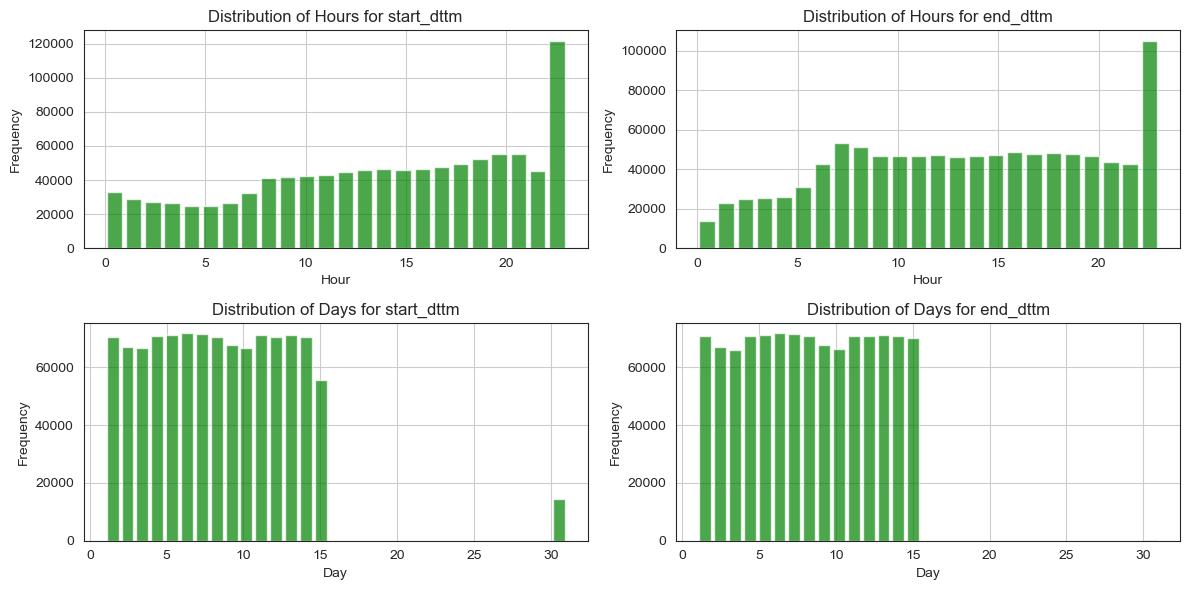

In [220]:
df_tracks['start_dttm_hour'] = df_tracks['start_dttm'].dt.hour
df_tracks['end_dttm_hour'] = df_tracks['end_dttm'].dt.hour

df_tracks['start_dttm_day'] = df_tracks['start_dttm'].dt.day
df_tracks['end_dttm_day'] = df_tracks['end_dttm'].dt.day

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
df_tracks['start_dttm_hour'].hist(bins=24, rwidth=0.8, color='green', alpha=0.7)
plt.title('Distribution of Hours for start_dttm')
plt.xlabel('Hour')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
df_tracks['end_dttm_hour'].hist(bins=24, rwidth=0.8, color='green', alpha=0.7)
plt.title('Distribution of Hours for end_dttm')
plt.xlabel('Hour')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
df_tracks['start_dttm_day'].hist(bins=31, rwidth=0.8, color='green', alpha=0.7)
plt.title('Distribution of Days for start_dttm')
plt.xlabel('Day')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
df_tracks['end_dttm_day'].hist(bins=31, rwidth=0.8, color='green', alpha=0.7)
plt.title('Distribution of Days for end_dttm')
plt.xlabel('Day')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [221]:
df_tracks['start_dttm_hour'].value_counts(normalize = True).head(10)

23    0.116090
21    0.052820
20    0.052572
19    0.049909
18    0.047017
17    0.045199
14    0.044566
16    0.044389
13    0.043805
15    0.043736
Name: start_dttm_hour, dtype: float64

In [222]:
df_tracks['duration_hours'] = round((df_tracks['end_dttm'] - df_tracks['start_dttm']).dt.total_seconds() / 3600, 2)  # Convert to hours

In [223]:
df_tracks['duration_hours'].value_counts(normalize = True).head(20)

1.00    0.090798
2.00    0.026546
1.50    0.018921
1.02    0.011731
3.00    0.011221
1.03    0.010432
1.05    0.009780
1.07    0.009280
1.08    0.008875
1.10    0.008832
2.50    0.008756
1.12    0.008577
1.13    0.008331
1.15    0.008048
4.00    0.007920
1.17    0.007833
1.18    0.007824
1.20    0.007409
1.22    0.007160
1.23    0.007101
Name: duration_hours, dtype: float64

## Most popular hexes

In [224]:
h3_9_counts = df_tracks['h3_9'].value_counts()
top_20_h3_9 = h3_9_counts.head(20)

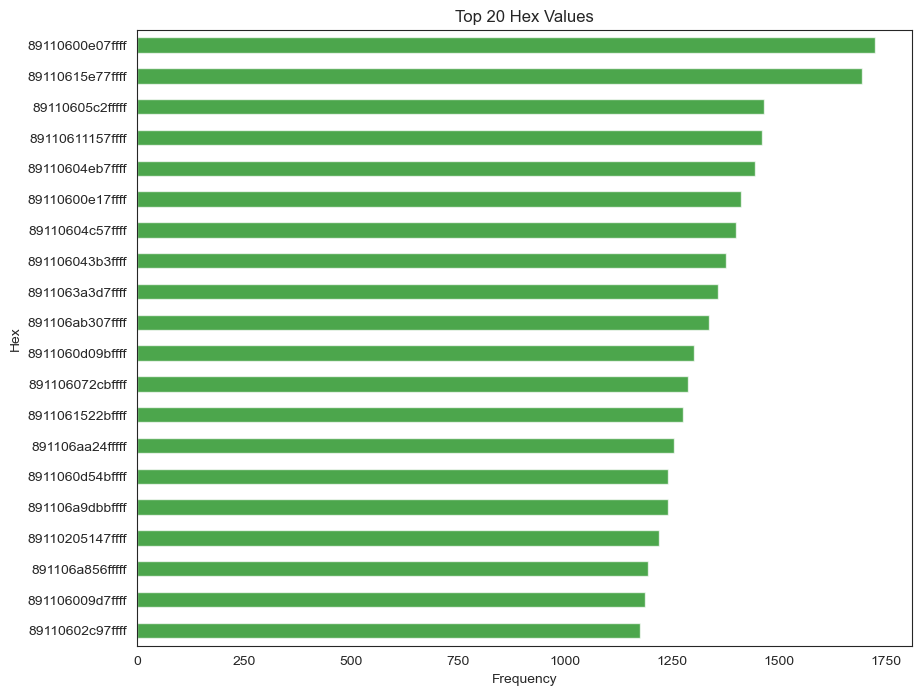

In [225]:
plt.figure(figsize=(10, 8))
top_20_h3_9.sort_values().plot(kind='barh', color='green', alpha=0.7)
plt.title('Top 20 Hex Values')
plt.xlabel('Frequency')
plt.ylabel('Hex')

plt.show()

## Hex df

**age**

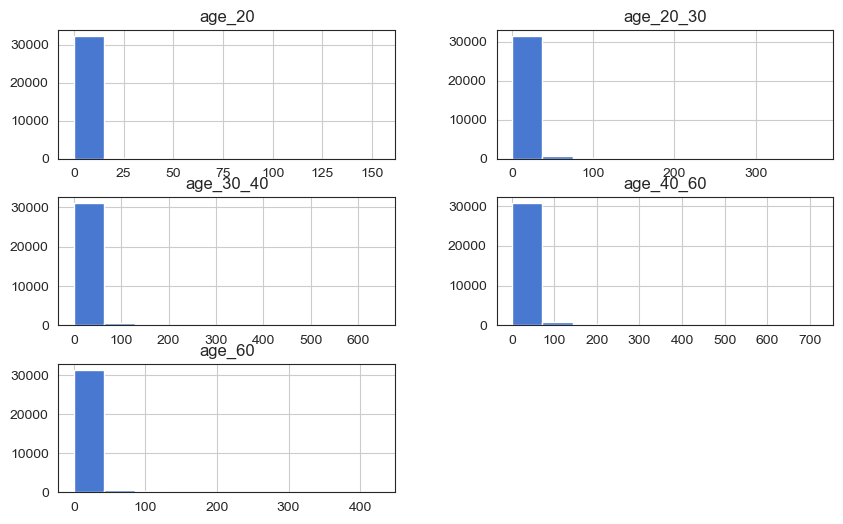

In [226]:
histograms = df_hex.iloc[:,:6].hist(figsize=(10,6))

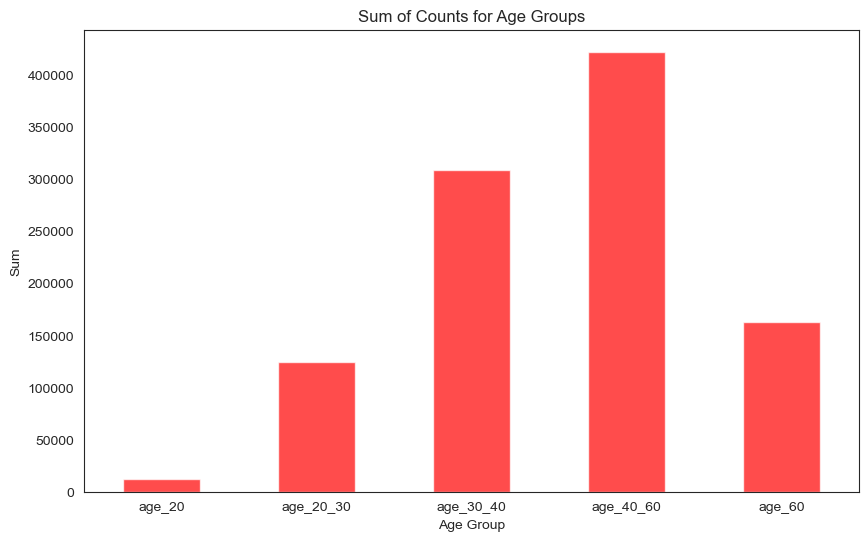

In [227]:
age_columns = ['age_20', 'age_20_30', 'age_30_40', 'age_40_60', 'age_60']

age_sums = df_hex[age_columns].sum()

plt.figure(figsize=(10, 6))
age_sums.plot(kind='bar', color='red', alpha=0.7)
plt.title('Sum of Counts for Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Sum')
plt.xticks(rotation=0)

plt.show()

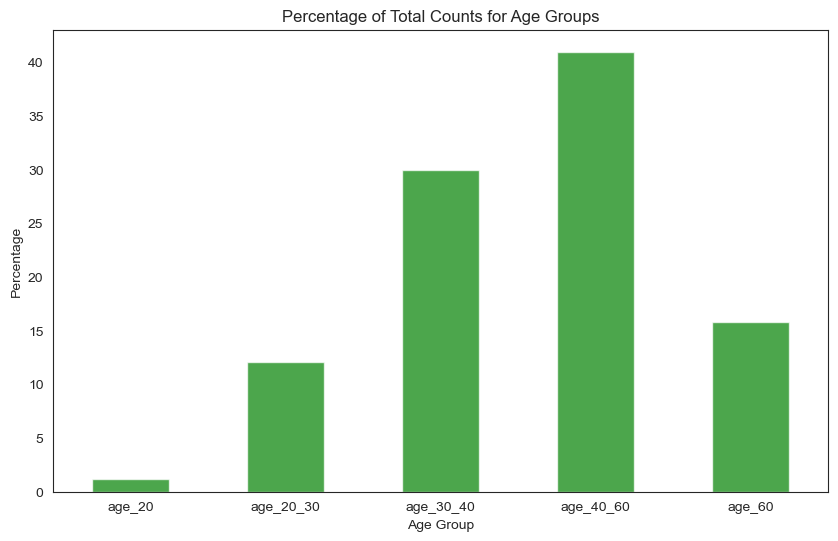

In [228]:
age_percentages = df_hex[age_columns].sum() / df_hex[age_columns].sum().sum() * 100

plt.figure(figsize=(10, 6))
age_percentages.plot(kind='bar', color='green', alpha=0.7)
plt.title('Percentage of Total Counts for Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

plt.show()

**salary**

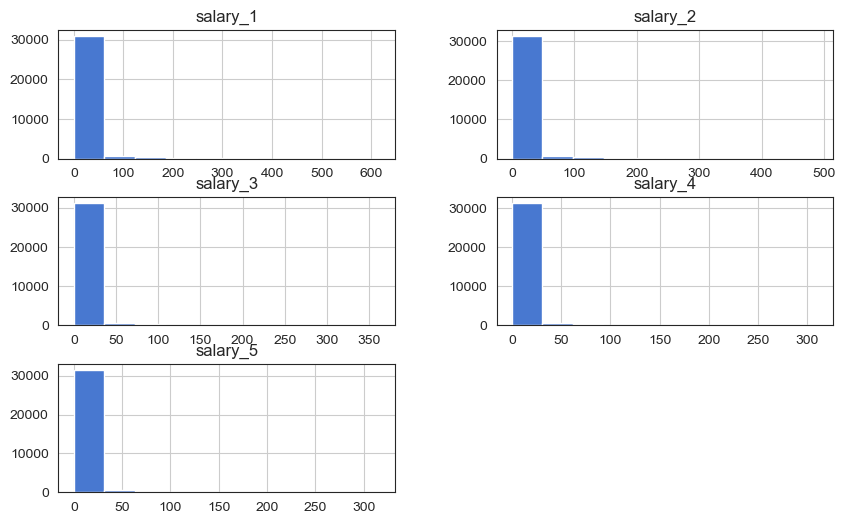

In [229]:
histograms = df_hex.iloc[:, -5:].hist(figsize=(10,6))

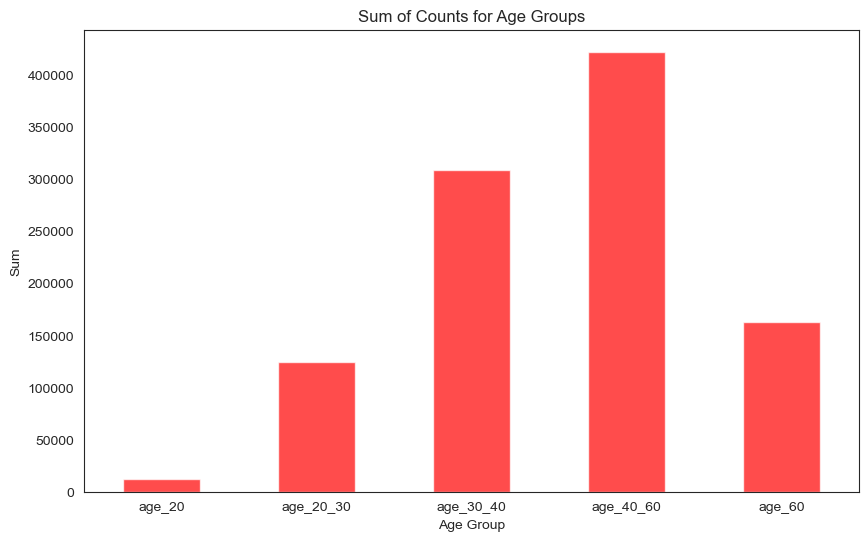

In [230]:
age_columns = ['age_20', 'age_20_30', 'age_30_40', 'age_40_60', 'age_60']

age_sums = df_hex[age_columns].sum()

plt.figure(figsize=(10, 6))
age_sums.plot(kind='bar', color='red', alpha=0.7)
plt.title('Sum of Counts for Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Sum')
plt.xticks(rotation=0)

plt.show()

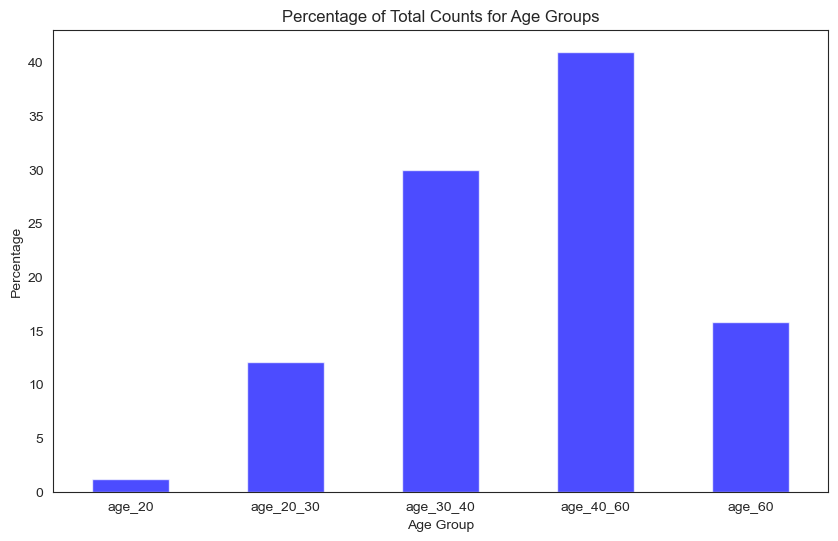

In [231]:
age_percentages = df_hex[age_columns].sum() / df_hex[age_columns].sum().sum() * 100

plt.figure(figsize=(10, 6))
age_percentages.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Percentage of Total Counts for Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

plt.show()

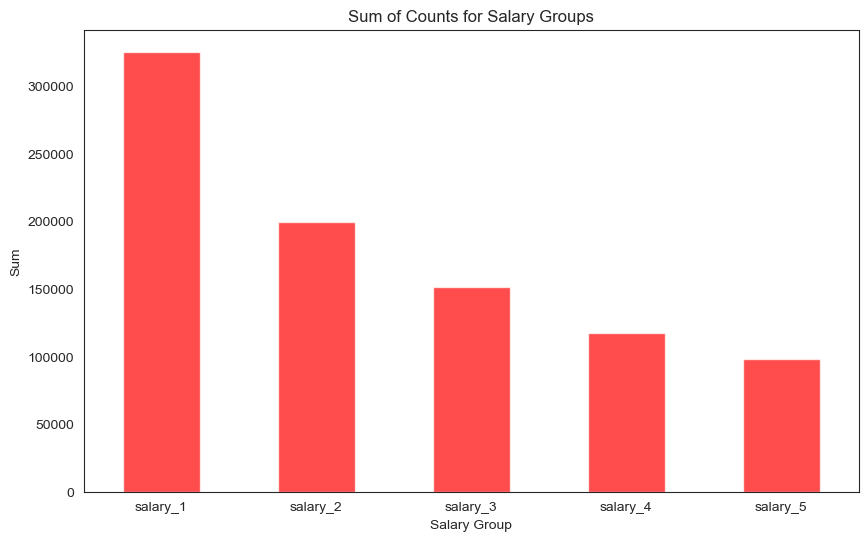

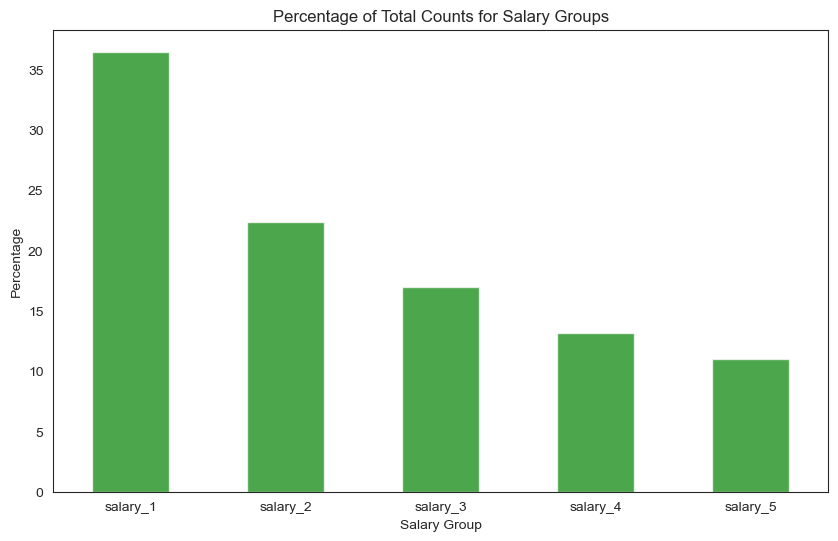

In [232]:
salary_columns = ['salary_1', 'salary_2', 'salary_3', 'salary_4', 'salary_5']

salary_sums = df_hex[salary_columns].sum()
plt.figure(figsize=(10, 6))
salary_sums.plot(kind='bar', color='red', alpha=0.7)
plt.title('Sum of Counts for Salary Groups')
plt.xlabel('Salary Group')
plt.ylabel('Sum')
plt.xticks(rotation=0)

plt.show()


salary_percentages = df_hex[salary_columns].sum() / df_hex[salary_columns].sum().sum() * 100
plt.figure(figsize=(10, 6))
salary_percentages.plot(kind='bar', color='green', alpha=0.7)
plt.title('Percentage of Total Counts for Salary Groups')
plt.xlabel('Salary Group')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

plt.show()

## Other stats

In [233]:
df_hex.head(5)

,h3_9,age_20,age_20_30,age_30_40,age_40_60,age_60,male,female,car_owners,carsharing_user,not_citizen_rf,public_trnsprt_user,healthy_food_inter,salary_1,salary_2,salary_3,salary_4,salary_5
0,8911063244fffff,0,0,8,3,1,7,5,4,5,2,0,0,1,6,2,2,1
1,891106074d7ffff,0,13,3,2,1,4,17,16,1,17,0,0,2,1,14,0,1
2,8911062a87bffff,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0
3,89110615e0fffff,0,2,11,20,15,46,19,14,0,22,1,0,33,12,2,7,4
4,892d721010bffff,0,0,2,1,1,3,1,0,0,0,0,0,2,1,0,0,0


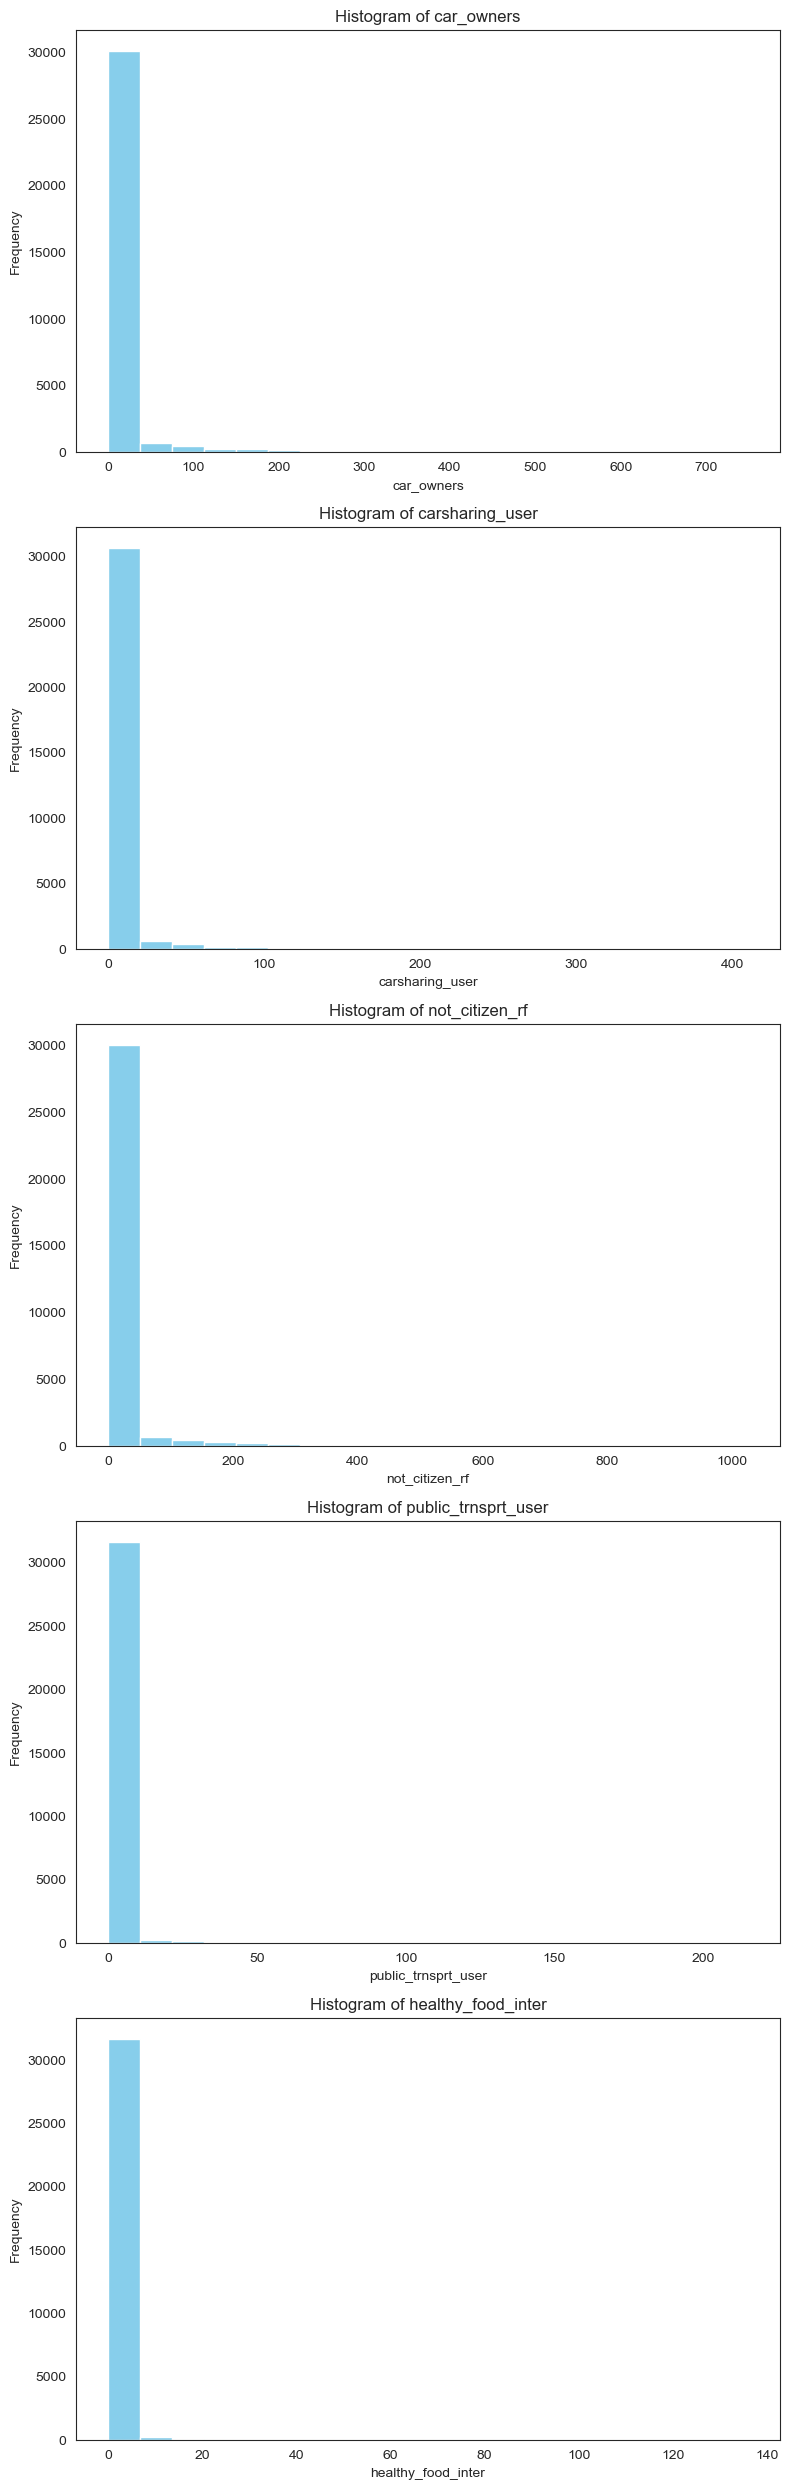

In [234]:
visualization_columns = ['car_owners', 'carsharing_user', 'not_citizen_rf', 'public_trnsprt_user', 'healthy_food_inter']

fig, axes = plt.subplots(nrows=len(visualization_columns), ncols=1, figsize=(8, 5 * len(visualization_columns)))

for i, column in enumerate(visualization_columns):
    axes[i].hist(df_hex[column], bins=20, color='skyblue')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Добавить распределения для каждой группы. Можем использовать box plot, будет лучше. ПЕРЕДЕЛАТЬ. Можно добавить распределения по гендерам. Использую cross-tab (interaction of num and cat data), summarize everything into several graphs. Normalize (or use log) for our data.  

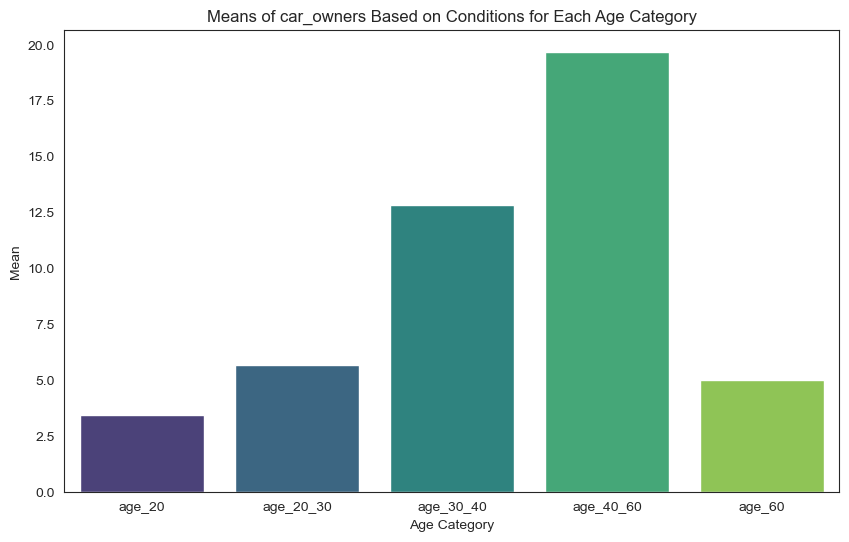

In [235]:
visualization_column = 'car_owners'
age_columns = ['age_20', 'age_20_30', 'age_30_40', 'age_40_60', 'age_60']

mean_age_20 = df_hex[(df_hex['age_20'] > df_hex['age_30_40']) & 
                    (df_hex['age_20'] > df_hex['age_20_30']) &
                    (df_hex['age_20'] > df_hex['age_40_60']) & 
                    (df_hex['age_20'] > df_hex['age_60'])].car_owners.mean()

mean_age_20_30 = df_hex[(df_hex['age_20_30'] > df_hex['age_20']) & 
                        (df_hex['age_20_30'] > df_hex['age_30_40']) &
                        (df_hex['age_20_30'] > df_hex['age_40_60']) & 
                        (df_hex['age_20_30'] > df_hex['age_60'])].car_owners.mean()

mean_age_30_40 = df_hex[(df_hex['age_30_40'] > df_hex['age_20']) & 
                        (df_hex['age_30_40'] > df_hex['age_20_30']) &
                        (df_hex['age_30_40'] > df_hex['age_40_60']) & 
                        (df_hex['age_30_40'] > df_hex['age_60'])].car_owners.mean()

mean_age_40_60 = df_hex[(df_hex['age_40_60'] > df_hex['age_20']) & 
                        (df_hex['age_40_60'] > df_hex['age_20_30']) &
                        (df_hex['age_40_60'] > df_hex['age_30_40']) & 
                        (df_hex['age_40_60'] > df_hex['age_60'])].car_owners.mean()

mean_age_60 = df_hex[(df_hex['age_60'] > df_hex['age_20']) & 
                     (df_hex['age_60'] > df_hex['age_20_30']) &
                     (df_hex['age_60'] > df_hex['age_30_40']) & 
                     (df_hex['age_60'] > df_hex['age_40_60'])].car_owners.mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=age_columns, y=[mean_age_20, mean_age_20_30, mean_age_30_40, mean_age_40_60, mean_age_60], palette='viridis')
plt.title(f'Means of {visualization_column} Based on Conditions for Each Age Category')
plt.xlabel('Age Category')
plt.ylabel('Mean')

plt.show()

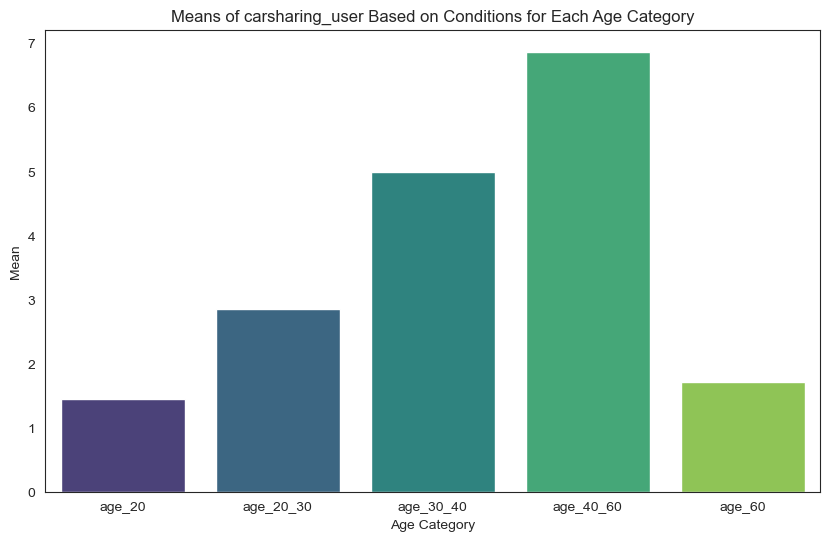

In [236]:
visualization_column = 'carsharing_user'
age_columns = ['age_20', 'age_20_30', 'age_30_40', 'age_40_60', 'age_60']

mean_age_20 = df_hex[(df_hex['age_20'] > df_hex['age_30_40']) & 
                    (df_hex['age_20'] > df_hex['age_20_30']) &
                    (df_hex['age_20'] > df_hex['age_40_60']) & 
                    (df_hex['age_20'] > df_hex['age_60'])].carsharing_user.mean()

mean_age_20_30 = df_hex[(df_hex['age_20_30'] > df_hex['age_20']) & 
                        (df_hex['age_20_30'] > df_hex['age_30_40']) &
                        (df_hex['age_20_30'] > df_hex['age_40_60']) & 
                        (df_hex['age_20_30'] > df_hex['age_60'])].carsharing_user.mean()

mean_age_30_40 = df_hex[(df_hex['age_30_40'] > df_hex['age_20']) & 
                        (df_hex['age_30_40'] > df_hex['age_20_30']) &
                        (df_hex['age_30_40'] > df_hex['age_40_60']) & 
                        (df_hex['age_30_40'] > df_hex['age_60'])].carsharing_user.mean()

mean_age_40_60 = df_hex[(df_hex['age_40_60'] > df_hex['age_20']) & 
                        (df_hex['age_40_60'] > df_hex['age_20_30']) &
                        (df_hex['age_40_60'] > df_hex['age_30_40']) & 
                        (df_hex['age_40_60'] > df_hex['age_60'])].carsharing_user.mean()

mean_age_60 = df_hex[(df_hex['age_60'] > df_hex['age_20']) & 
                     (df_hex['age_60'] > df_hex['age_20_30']) &
                     (df_hex['age_60'] > df_hex['age_30_40']) & 
                     (df_hex['age_60'] > df_hex['age_40_60'])].carsharing_user.mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=age_columns, y=[mean_age_20, mean_age_20_30, mean_age_30_40, mean_age_40_60, mean_age_60], palette='viridis')
plt.title(f'Means of {visualization_column} Based on Conditions for Each Age Category')
plt.xlabel('Age Category')
plt.ylabel('Mean')

plt.show()

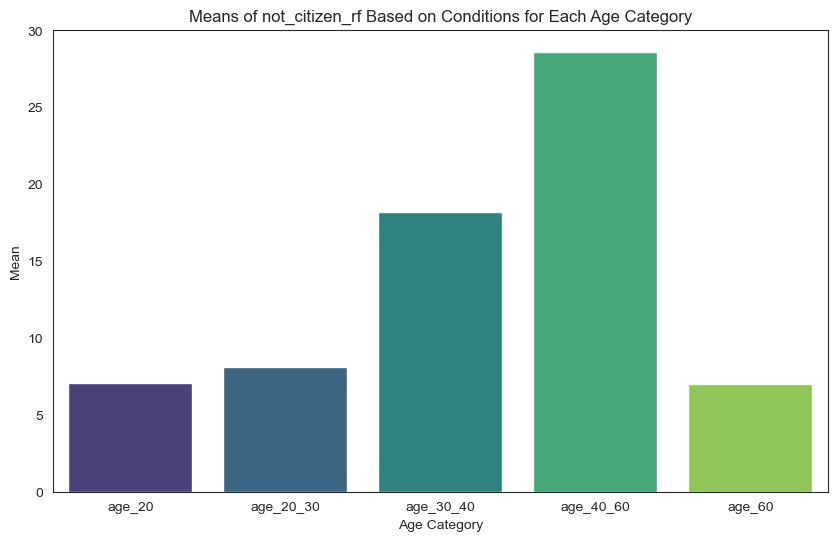

In [237]:
visualization_column = 'not_citizen_rf'
age_columns = ['age_20', 'age_20_30', 'age_30_40', 'age_40_60', 'age_60']

mean_age_20 = df_hex[(df_hex['age_20'] > df_hex['age_30_40']) & 
                    (df_hex['age_20'] > df_hex['age_20_30']) &
                    (df_hex['age_20'] > df_hex['age_40_60']) & 
                    (df_hex['age_20'] > df_hex['age_60'])].not_citizen_rf.mean()

mean_age_20_30 = df_hex[(df_hex['age_20_30'] > df_hex['age_20']) & 
                        (df_hex['age_20_30'] > df_hex['age_30_40']) &
                        (df_hex['age_20_30'] > df_hex['age_40_60']) & 
                        (df_hex['age_20_30'] > df_hex['age_60'])].not_citizen_rf.mean()

mean_age_30_40 = df_hex[(df_hex['age_30_40'] > df_hex['age_20']) & 
                        (df_hex['age_30_40'] > df_hex['age_20_30']) &
                        (df_hex['age_30_40'] > df_hex['age_40_60']) & 
                        (df_hex['age_30_40'] > df_hex['age_60'])].not_citizen_rf.mean()

mean_age_40_60 = df_hex[(df_hex['age_40_60'] > df_hex['age_20']) & 
                        (df_hex['age_40_60'] > df_hex['age_20_30']) &
                        (df_hex['age_40_60'] > df_hex['age_30_40']) & 
                        (df_hex['age_40_60'] > df_hex['age_60'])].not_citizen_rf.mean()

mean_age_60 = df_hex[(df_hex['age_60'] > df_hex['age_20']) & 
                     (df_hex['age_60'] > df_hex['age_20_30']) &
                     (df_hex['age_60'] > df_hex['age_30_40']) & 
                     (df_hex['age_60'] > df_hex['age_40_60'])].not_citizen_rf.mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=age_columns, y=[mean_age_20, mean_age_20_30, mean_age_30_40, mean_age_40_60, mean_age_60], palette='viridis')
plt.title(f'Means of {visualization_column} Based on Conditions for Each Age Category')
plt.xlabel('Age Category')
plt.ylabel('Mean')

plt.show()

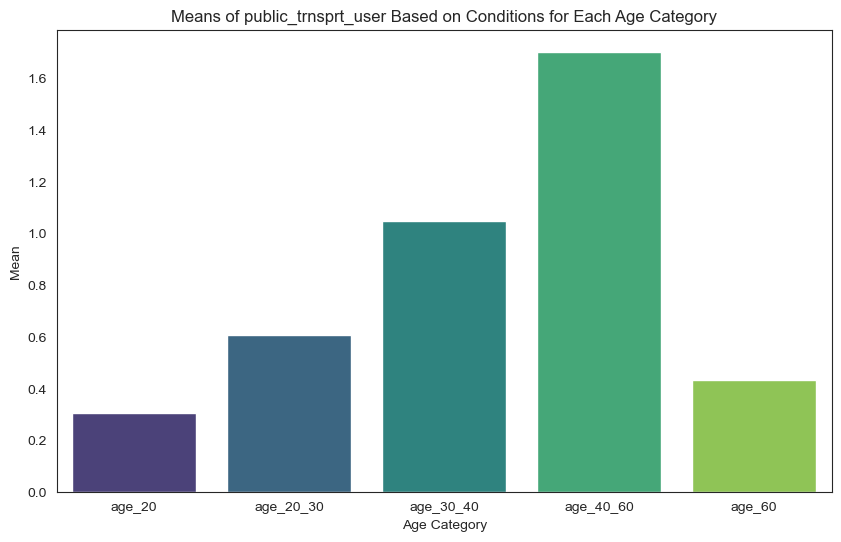

In [238]:
visualization_column = 'public_trnsprt_user'
age_columns = ['age_20', 'age_20_30', 'age_30_40', 'age_40_60', 'age_60']

mean_age_20 = df_hex[(df_hex['age_20'] > df_hex['age_30_40']) & 
                    (df_hex['age_20'] > df_hex['age_20_30']) &
                    (df_hex['age_20'] > df_hex['age_40_60']) & 
                    (df_hex['age_20'] > df_hex['age_60'])].public_trnsprt_user.mean()

mean_age_20_30 = df_hex[(df_hex['age_20_30'] > df_hex['age_20']) & 
                        (df_hex['age_20_30'] > df_hex['age_30_40']) &
                        (df_hex['age_20_30'] > df_hex['age_40_60']) & 
                        (df_hex['age_20_30'] > df_hex['age_60'])].public_trnsprt_user.mean()

mean_age_30_40 = df_hex[(df_hex['age_30_40'] > df_hex['age_20']) & 
                        (df_hex['age_30_40'] > df_hex['age_20_30']) &
                        (df_hex['age_30_40'] > df_hex['age_40_60']) & 
                        (df_hex['age_30_40'] > df_hex['age_60'])].public_trnsprt_user.mean()

mean_age_40_60 = df_hex[(df_hex['age_40_60'] > df_hex['age_20']) & 
                        (df_hex['age_40_60'] > df_hex['age_20_30']) &
                        (df_hex['age_40_60'] > df_hex['age_30_40']) & 
                        (df_hex['age_40_60'] > df_hex['age_60'])].public_trnsprt_user.mean()

mean_age_60 = df_hex[(df_hex['age_60'] > df_hex['age_20']) & 
                     (df_hex['age_60'] > df_hex['age_20_30']) &
                     (df_hex['age_60'] > df_hex['age_30_40']) & 
                     (df_hex['age_60'] > df_hex['age_40_60'])].public_trnsprt_user.mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=age_columns, y=[mean_age_20, mean_age_20_30, mean_age_30_40, mean_age_40_60, mean_age_60], palette='viridis')
plt.title(f'Means of {visualization_column} Based on Conditions for Each Age Category')
plt.xlabel('Age Category')
plt.ylabel('Mean')

plt.show()

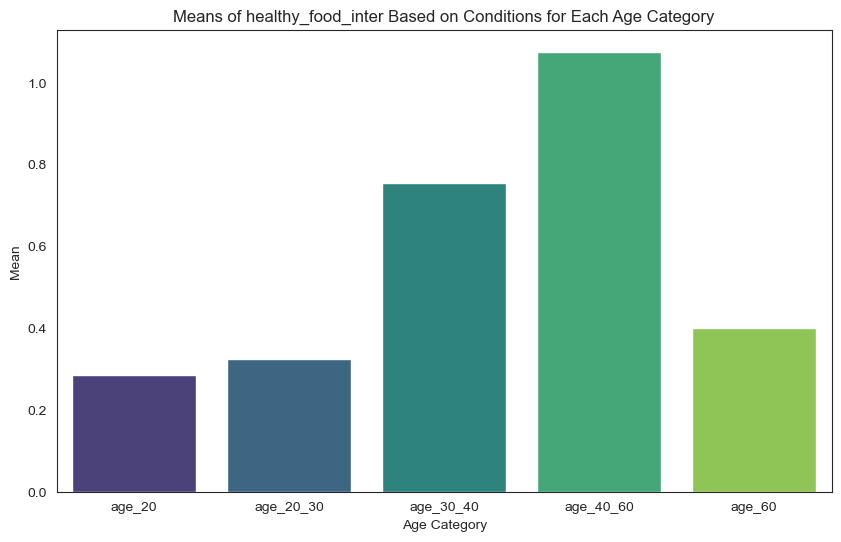

In [239]:
visualization_column = 'healthy_food_inter'
age_columns = ['age_20', 'age_20_30', 'age_30_40', 'age_40_60', 'age_60']

mean_age_20 = df_hex[(df_hex['age_20'] > df_hex['age_30_40']) & 
                    (df_hex['age_20'] > df_hex['age_20_30']) &
                    (df_hex['age_20'] > df_hex['age_40_60']) & 
                    (df_hex['age_20'] > df_hex['age_60'])].healthy_food_inter.mean()

mean_age_20_30 = df_hex[(df_hex['age_20_30'] > df_hex['age_20']) & 
                        (df_hex['age_20_30'] > df_hex['age_30_40']) &
                        (df_hex['age_20_30'] > df_hex['age_40_60']) & 
                        (df_hex['age_20_30'] > df_hex['age_60'])].healthy_food_inter.mean()

mean_age_30_40 = df_hex[(df_hex['age_30_40'] > df_hex['age_20']) & 
                        (df_hex['age_30_40'] > df_hex['age_20_30']) &
                        (df_hex['age_30_40'] > df_hex['age_40_60']) & 
                        (df_hex['age_30_40'] > df_hex['age_60'])].healthy_food_inter.mean()

mean_age_40_60 = df_hex[(df_hex['age_40_60'] > df_hex['age_20']) & 
                        (df_hex['age_40_60'] > df_hex['age_20_30']) &
                        (df_hex['age_40_60'] > df_hex['age_30_40']) & 
                        (df_hex['age_40_60'] > df_hex['age_60'])].healthy_food_inter.mean()

mean_age_60 = df_hex[(df_hex['age_60'] > df_hex['age_20']) & 
                     (df_hex['age_60'] > df_hex['age_20_30']) &
                     (df_hex['age_60'] > df_hex['age_30_40']) & 
                     (df_hex['age_60'] > df_hex['age_40_60'])].healthy_food_inter.mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=age_columns, y=[mean_age_20, mean_age_20_30, mean_age_30_40, mean_age_40_60, mean_age_60], palette='viridis')
plt.title(f'Means of {visualization_column} Based on Conditions for Each Age Category')
plt.xlabel('Age Category')
plt.ylabel('Mean')

plt.show()

**For salary**

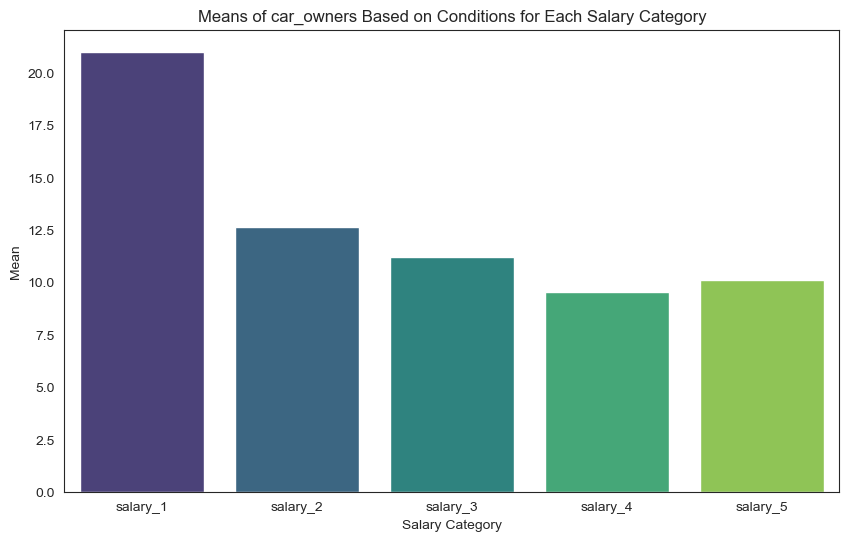

In [240]:
visualization_column = 'car_owners'
salary_columns = ['salary_1', 'salary_2', 'salary_3', 'salary_4', 'salary_5']

mean_salary_1 = df_hex[(df_hex['salary_1'] > df_hex['salary_2']) & 
                    (df_hex['salary_1'] > df_hex['salary_3']) &
                    (df_hex['salary_1'] > df_hex['salary_4']) & 
                    (df_hex['salary_1'] > df_hex['salary_5'])].car_owners.mean()

mean_salary_2 = df_hex[(df_hex['salary_2'] > df_hex['salary_1']) & 
                        (df_hex['salary_2'] > df_hex['salary_3']) &
                        (df_hex['salary_2'] > df_hex['salary_4']) & 
                        (df_hex['salary_2'] > df_hex['salary_5'])].car_owners.mean()

mean_salary_3 = df_hex[(df_hex['salary_3'] > df_hex['salary_1']) & 
                        (df_hex['salary_3'] > df_hex['salary_2']) &
                        (df_hex['salary_3'] > df_hex['salary_4']) & 
                        (df_hex['salary_3'] > df_hex['salary_5'])].car_owners.mean()

mean_salary_4 = df_hex[(df_hex['salary_4'] > df_hex['salary_1']) & 
                        (df_hex['salary_4'] > df_hex['salary_2']) &
                        (df_hex['salary_4'] > df_hex['salary_3']) & 
                        (df_hex['salary_4'] > df_hex['salary_5'])].car_owners.mean()

mean_salary_5 = df_hex[(df_hex['salary_5'] > df_hex['salary_1']) & 
                     (df_hex['salary_5'] > df_hex['salary_2']) &
                     (df_hex['salary_5'] > df_hex['salary_3']) & 
                     (df_hex['salary_5'] > df_hex['salary_4'])].car_owners.mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=salary_columns, y=[mean_salary_1, mean_salary_2, mean_salary_3, mean_salary_4, mean_salary_5], palette='viridis')
plt.title(f'Means of {visualization_column} Based on Conditions for Each Salary Category')
plt.xlabel('Salary Category')
plt.ylabel('Mean')

plt.show()

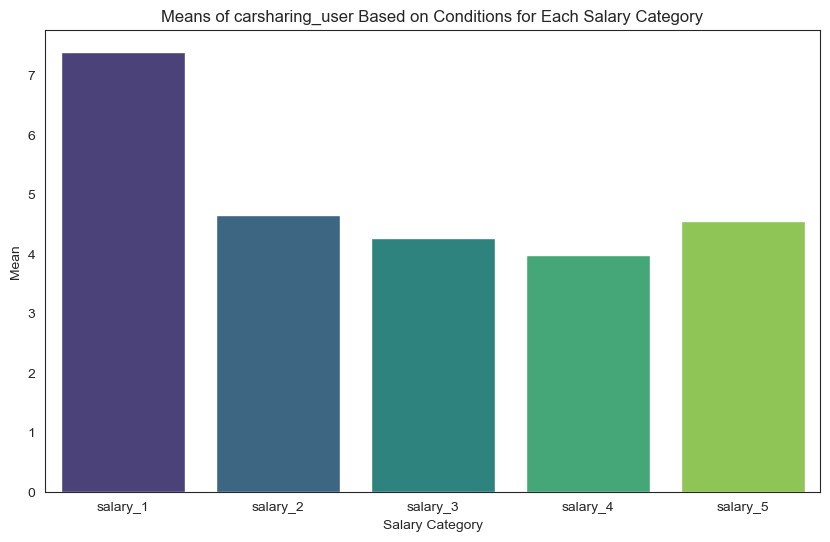

In [242]:
visualization_column = 'carsharing_user'
salary_columns = ['salary_1', 'salary_2', 'salary_3', 'salary_4', 'salary_5']

mean_salary_1 = df_hex[(df_hex['salary_1'] > df_hex['salary_2']) & 
                    (df_hex['salary_1'] > df_hex['salary_3']) &
                    (df_hex['salary_1'] > df_hex['salary_4']) & 
                    (df_hex['salary_1'] > df_hex['salary_5'])].carsharing_user.mean()

mean_salary_2 = df_hex[(df_hex['salary_2'] > df_hex['salary_1']) & 
                        (df_hex['salary_2'] > df_hex['salary_3']) &
                        (df_hex['salary_2'] > df_hex['salary_4']) & 
                        (df_hex['salary_2'] > df_hex['salary_5'])].carsharing_user.mean()

mean_salary_3 = df_hex[(df_hex['salary_3'] > df_hex['salary_1']) & 
                        (df_hex['salary_3'] > df_hex['salary_2']) &
                        (df_hex['salary_3'] > df_hex['salary_4']) & 
                        (df_hex['salary_3'] > df_hex['salary_5'])].carsharing_user.mean()

mean_salary_4 = df_hex[(df_hex['salary_4'] > df_hex['salary_1']) & 
                        (df_hex['salary_4'] > df_hex['salary_2']) &
                        (df_hex['salary_4'] > df_hex['salary_3']) & 
                        (df_hex['salary_4'] > df_hex['salary_5'])].carsharing_user.mean()

mean_salary_5 = df_hex[(df_hex['salary_5'] > df_hex['salary_1']) & 
                     (df_hex['salary_5'] > df_hex['salary_2']) &
                     (df_hex['salary_5'] > df_hex['salary_3']) & 
                     (df_hex['salary_5'] > df_hex['salary_4'])].carsharing_user.mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=salary_columns, y=[mean_salary_1, mean_salary_2, mean_salary_3, mean_salary_4, mean_salary_5], palette='viridis')
plt.title(f'Means of {visualization_column} Based on Conditions for Each Salary Category')
plt.xlabel('Salary Category')
plt.ylabel('Mean')

plt.show()

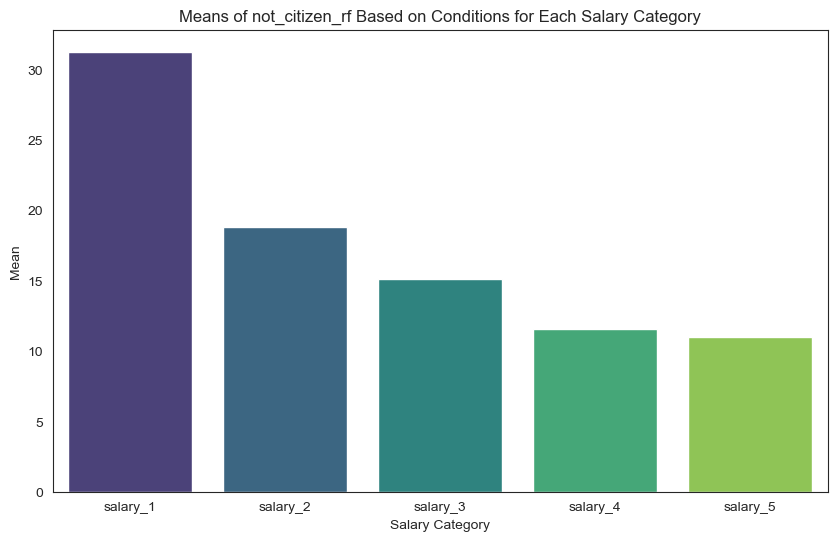

In [243]:
visualization_column = 'not_citizen_rf'
salary_columns = ['salary_1', 'salary_2', 'salary_3', 'salary_4', 'salary_5']

mean_salary_1 = df_hex[(df_hex['salary_1'] > df_hex['salary_2']) & 
                    (df_hex['salary_1'] > df_hex['salary_3']) &
                    (df_hex['salary_1'] > df_hex['salary_4']) & 
                    (df_hex['salary_1'] > df_hex['salary_5'])].not_citizen_rf.mean()

mean_salary_2 = df_hex[(df_hex['salary_2'] > df_hex['salary_1']) & 
                        (df_hex['salary_2'] > df_hex['salary_3']) &
                        (df_hex['salary_2'] > df_hex['salary_4']) & 
                        (df_hex['salary_2'] > df_hex['salary_5'])].not_citizen_rf.mean()

mean_salary_3 = df_hex[(df_hex['salary_3'] > df_hex['salary_1']) & 
                        (df_hex['salary_3'] > df_hex['salary_2']) &
                        (df_hex['salary_3'] > df_hex['salary_4']) & 
                        (df_hex['salary_3'] > df_hex['salary_5'])].not_citizen_rf.mean()

mean_salary_4 = df_hex[(df_hex['salary_4'] > df_hex['salary_1']) & 
                        (df_hex['salary_4'] > df_hex['salary_2']) &
                        (df_hex['salary_4'] > df_hex['salary_3']) & 
                        (df_hex['salary_4'] > df_hex['salary_5'])].not_citizen_rf.mean()

mean_salary_5 = df_hex[(df_hex['salary_5'] > df_hex['salary_1']) & 
                     (df_hex['salary_5'] > df_hex['salary_2']) &
                     (df_hex['salary_5'] > df_hex['salary_3']) & 
                     (df_hex['salary_5'] > df_hex['salary_4'])].not_citizen_rf.mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=salary_columns, y=[mean_salary_1, mean_salary_2, mean_salary_3, mean_salary_4, mean_salary_5], palette='viridis')
plt.title(f'Means of {visualization_column} Based on Conditions for Each Salary Category')
plt.xlabel('Salary Category')
plt.ylabel('Mean')

plt.show()

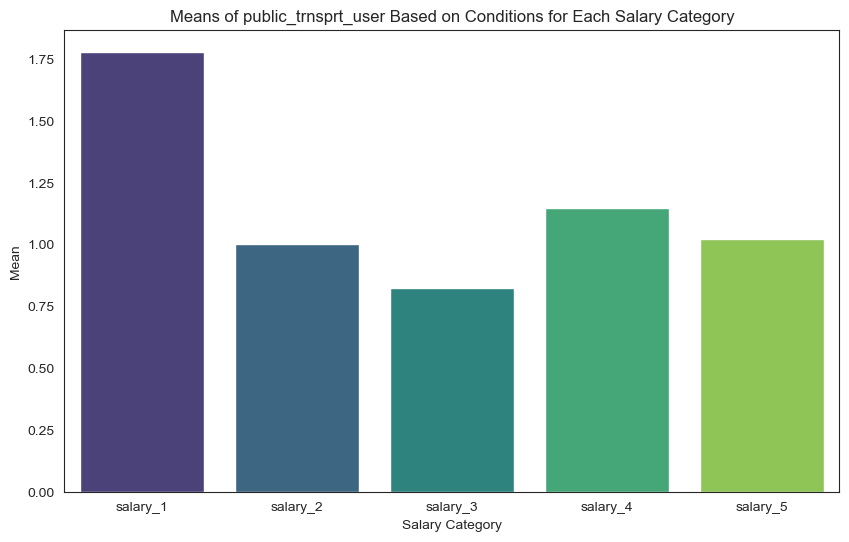

In [244]:
visualization_column = 'public_trnsprt_user'
salary_columns = ['salary_1', 'salary_2', 'salary_3', 'salary_4', 'salary_5']

mean_salary_1 = df_hex[(df_hex['salary_1'] > df_hex['salary_2']) & 
                    (df_hex['salary_1'] > df_hex['salary_3']) &
                    (df_hex['salary_1'] > df_hex['salary_4']) & 
                    (df_hex['salary_1'] > df_hex['salary_5'])].public_trnsprt_user.mean()

mean_salary_2 = df_hex[(df_hex['salary_2'] > df_hex['salary_1']) & 
                        (df_hex['salary_2'] > df_hex['salary_3']) &
                        (df_hex['salary_2'] > df_hex['salary_4']) & 
                        (df_hex['salary_2'] > df_hex['salary_5'])].public_trnsprt_user.mean()

mean_salary_3 = df_hex[(df_hex['salary_3'] > df_hex['salary_1']) & 
                        (df_hex['salary_3'] > df_hex['salary_2']) &
                        (df_hex['salary_3'] > df_hex['salary_4']) & 
                        (df_hex['salary_3'] > df_hex['salary_5'])].public_trnsprt_user.mean()

mean_salary_4 = df_hex[(df_hex['salary_4'] > df_hex['salary_1']) & 
                        (df_hex['salary_4'] > df_hex['salary_2']) &
                        (df_hex['salary_4'] > df_hex['salary_3']) & 
                        (df_hex['salary_4'] > df_hex['salary_5'])].public_trnsprt_user.mean()

mean_salary_5 = df_hex[(df_hex['salary_5'] > df_hex['salary_1']) & 
                     (df_hex['salary_5'] > df_hex['salary_2']) &
                     (df_hex['salary_5'] > df_hex['salary_3']) & 
                     (df_hex['salary_5'] > df_hex['salary_4'])].public_trnsprt_user.mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=salary_columns, y=[mean_salary_1, mean_salary_2, mean_salary_3, mean_salary_4, mean_salary_5], palette='viridis')
plt.title(f'Means of {visualization_column} Based on Conditions for Each Salary Category')
plt.xlabel('Salary Category')
plt.ylabel('Mean')

plt.show()

## Checkers for Hex df

In [245]:
age_columns = ['age_20', 'age_20_30', 'age_30_40', 'age_40_60', 'age_60']
salary_columns = ['salary_1', 'salary_2', 'salary_3', 'salary_4', 'salary_5']
gender_columns = ['male', 'female']

df_hex['total_age'] = df_hex[age_columns].sum(axis=1)
df_hex['total_salary'] = df_hex[salary_columns].sum(axis=1)
df_hex['total_gender'] = df_hex[gender_columns].sum(axis=1)

df_hex.head(5)

,h3_9,age_20,age_20_30,age_30_40,age_40_60,age_60,male,female,car_owners,carsharing_user,not_citizen_rf,public_trnsprt_user,healthy_food_inter,salary_1,salary_2,salary_3,salary_4,salary_5,total_age,total_salary,total_gender
0,8911063244fffff,0,0,8,3,1,7,5,4,5,2,0,0,1,6,2,2,1,12,12,12
1,891106074d7ffff,0,13,3,2,1,4,17,16,1,17,0,0,2,1,14,0,1,19,18,21
2,8911062a87bffff,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,1,1
3,89110615e0fffff,0,2,11,20,15,46,19,14,0,22,1,0,33,12,2,7,4,48,58,65
4,892d721010bffff,0,0,2,1,1,3,1,0,0,0,0,0,2,1,0,0,0,4,3,4


In [246]:
total_age_equal_total_salary = (df_hex['total_age'] == df_hex['total_salary']).sum()
total_age_less_than_total_salary = (df_hex['total_age'] < df_hex['total_salary']).sum()
total_age_more_than_total_salary = (df_hex['total_age'] > df_hex['total_salary']).sum()

amount_percentage_total_age_salary = {
    'Equal': total_age_equal_total_salary,
    'Less Than': total_age_less_than_total_salary,
    'More Than': total_age_more_than_total_salary
}

total_salary_equal_total_gender = (df_hex['total_salary'] == df_hex['total_gender']).sum()
total_salary_less_than_total_gender = (df_hex['total_salary'] < df_hex['total_gender']).sum()
total_salary_more_than_total_gender = (df_hex['total_salary'] > df_hex['total_gender']).sum()

amount_percentage_total_salary_gender = {
    'Equal': total_salary_equal_total_gender,
    'Less Than': total_salary_less_than_total_gender,
    'More Than': total_salary_more_than_total_gender
}

total_age_equal_total_gender = (df_hex['total_age'] == df_hex['total_gender']).sum()
total_age_less_than_total_gender = (df_hex['total_age'] < df_hex['total_gender']).sum()
total_age_more_than_total_gender = (df_hex['total_age'] > df_hex['total_gender']).sum()

amount_percentage_total_age_gender = {
    'Equal': total_age_equal_total_gender,
    'Less Than': total_age_less_than_total_gender,
    'More Than': total_age_more_than_total_gender
}

total_age_equal_total_salary = round((df_hex['total_age'] == df_hex['total_salary']).sum() / len(df_hex) * 100, 2)
total_age_less_than_total_salary = round((df_hex['total_age'] < df_hex['total_salary']).sum() / len(df_hex) * 100, 2)
total_age_more_than_total_salary = round((df_hex['total_age'] > df_hex['total_salary']).sum() / len(df_hex) * 100, 2)

percentage_total_age_salary = {
    'Equal': total_age_equal_total_salary,
    'Less Than': total_age_less_than_total_salary,
    'More Than': total_age_more_than_total_salary
}

total_salary_equal_total_gender = round((df_hex['total_salary'] == df_hex['total_gender']).sum() / len(df_hex) * 100, 2)
total_salary_less_than_total_gender = round((df_hex['total_salary'] < df_hex['total_gender']).sum() / len(df_hex) * 100, 2)
total_salary_more_than_total_gender = round((df_hex['total_salary'] > df_hex['total_gender']).sum() / len(df_hex) * 100, 2)

percentage_total_salary_gender = {
    'Equal': total_salary_equal_total_gender,
    'Less Than': total_salary_less_than_total_gender,
    'More Than': total_salary_more_than_total_gender
}

total_age_equal_total_gender = round((df_hex['total_age'] == df_hex['total_gender']).sum() / len(df_hex) * 100, 2)
total_age_less_than_total_gender = round((df_hex['total_age'] < df_hex['total_gender']).sum() / len(df_hex) * 100, 2)
total_age_more_than_total_gender = round((df_hex['total_age'] > df_hex['total_gender']).sum() / len(df_hex) * 100, 2)

percentage_total_age_gender = {
    'Equal': total_age_equal_total_gender,
    'Less Than': total_age_less_than_total_gender,
    'More Than': total_age_more_than_total_gender
}

In [247]:
print("Statistics for total_age and total_salary:")
print(amount_percentage_total_age_salary)

print("\nStatistics for total_salary and total_gender:")
print(amount_percentage_total_salary_gender)

print("\nStatistics for total_age and total_gender:")
print(amount_percentage_total_age_gender)

Statistics for total_age and total_salary:
{'Equal': 21465, 'Less Than': 1249, 'More Than': 9708}

Statistics for total_salary and total_gender:
{'Equal': 19957, 'Less Than': 12465, 'More Than': 0}

Statistics for total_age and total_gender:
{'Equal': 25779, 'Less Than': 6643, 'More Than': 0}


In [248]:
print("Percentage Statistics for total_age and total_salary:")
print(percentage_total_age_salary)

print("\nPercentage Statistics for total_salary and total_gender:")
print(percentage_total_salary_gender)

print("\nPercentage Statistics for total_age and total_gender:")
print(percentage_total_age_gender)

Percentage Statistics for total_age and total_salary:
{'Equal': 66.21, 'Less Than': 3.85, 'More Than': 29.94}

Percentage Statistics for total_salary and total_gender:
{'Equal': 61.55, 'Less Than': 38.45, 'More Than': 0.0}

Percentage Statistics for total_age and total_gender:
{'Equal': 79.51, 'Less Than': 20.49, 'More Than': 0.0}


## Another Checkers

In [251]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [252]:
%config InlineBackend.figure_format = 'retina'

In [250]:
numeric_cols = ['age_20', 'age_20_30', 'age_30_40', 'age_40_60', 'age_60',
                'salary_1', 'salary_2', 'salary_3', 'salary_4', 'salary_5',
                'male', 'female',
                'car_owners', 'carsharing_user', 'not_citizen_rf', 'public_trnsprt_user', 'healthy_food_inter']
outliers_remedy = pd.DataFrame(columns=numeric_cols)

for column in numeric_cols:
    column_data = df_hex[column][df_hex[column] != 0]
    iqr = scipy.stats.iqr(column_data)
    q1 = np.quantile(column_data, .25)
    q3 = np.quantile(column_data, .75)
    outliers_remedy[column] = [q1-1.5*iqr, q3+5*iqr]

outliers_remedy

,age_20,age_20_30,age_30_40,age_40_60,age_60,salary_1,salary_2,salary_3,salary_4,salary_5,male,female,car_owners,carsharing_user,not_citizen_rf,public_trnsprt_user,healthy_food_inter
0,-6.5,-15.5,-12.5,-14.0,-15.5,-12.5,-17.0,-15.5,-15.5,-15.5,-11.0,-12.5,-12.5,-15.5,-11.0,-9.5,-8.375
1,31.0,67.0,55.0,61.0,67.0,55.0,73.0,67.0,67.0,67.0,49.0,55.0,55.0,67.0,49.0,43.0,38.500


In [253]:
for column in numeric_cols:
    column_data = df_hex[column][df_hex[column] != 0]
    print(color.BOLD + column + color.END)
    print('Нижний (0.25) квантиль:', round(column_data.quantile(0.25),2))
    print('Средний (0.5) квантиль:', round(column_data.quantile(0.5),2))
    print('Верхний (0.75) квантиль:', round(column_data.quantile(0.75),2))
    print('0.9-ый квантиль:', round(column_data.quantile(0.9),2))
    print('0.97-ой квантиль:', round(column_data.quantile(0.97),2))
    print()

age_20
Нижний (0.25) квантиль: 1.0
Средний (0.5) квантиль: 2.0
Верхний (0.75) квантиль: 6.0
0.9-ый квантиль: 22.0
0.97-ой квантиль: 48.24

age_20_30
Нижний (0.25) квантиль: 1.0
Средний (0.5) квантиль: 2.0
Верхний (0.75) квантиль: 12.0
0.9-ый квантиль: 46.0
0.97-ой квантиль: 96.0

age_30_40
Нижний (0.25) квантиль: 1.0
Средний (0.5) квантиль: 2.0
Верхний (0.75) квантиль: 10.0
0.9-ый квантиль: 63.0
0.97-ой квантиль: 176.57

age_40_60
Нижний (0.25) квантиль: 1.0
Средний (0.5) квантиль: 2.0
Верхний (0.75) квантиль: 11.0
0.9-ый квантиль: 71.0
0.97-ой квантиль: 216.0

age_60
Нижний (0.25) квантиль: 1.0
Средний (0.5) квантиль: 2.0
Верхний (0.75) квантиль: 12.0
0.9-ый квантиль: 51.0
0.97-ой квантиль: 118.0

salary_1
Нижний (0.25) квантиль: 1.0
Средний (0.5) квантиль: 2.0
Верхний (0.75) квантиль: 10.0
0.9-ый квантиль: 64.2
0.97-ой квантиль: 179.26

salary_2
Нижний (0.25) квантиль: 1.0
Средний (0.5) квантиль: 2.0
Верхний (0.75) квантиль: 13.0
0.9-ый квантиль: 59.0
0.97-ой квантиль: 133.0

salary_

In [256]:
df_hex[(df_hex['male']>300) & (df_hex['female']<1)]

,h3_9,age_20,age_20_30,age_30_40,age_40_60,age_60,male,female,car_owners,carsharing_user,not_citizen_rf,public_trnsprt_user,healthy_food_inter,salary_1,salary_2,salary_3,salary_4,salary_5,total_age,total_salary,total_gender
2810,89110219223ffff,0,116,103,1,120,348,0,200,84,89,1,0,155,1,49,0,116,340,321,348


## Maybe transform task to prediction. If we have no data about hex then we use data about this hex to predict smth (f.i. amount of users)

## Use External data. Put categories: beauty, military and son (take it from external source)

## Use Data Lens daataset